In [1]:
from collections import defaultdict
import re
import pandas

In [2]:
evaluating = re.compile("Evaluating models_for_gan/cremmalab5\.?(?P<bw>nobw)?\.nfc-0\.(?P<score>\d+)\.mlmodel\s*")
test_file = re.compile("Testing ./test-microfilm-(?P<mss>\d+).txt (?P<mode>[\w\s]+)")
accuracy = re.compile("(?P<acc>[\d\.]+)%\s+Accuracy")
characters = re.compile("(?P<chr>\d+)\s+Characters")
errors = re.compile("(?P<chr>\d+)\s+Errors")

# TESTFILE:./prediction/htr/test-sets/colorized-125v-126r.xml.txt
# MODEL:./models/htr/cremmalabMICROFILM.nfc.noaugment_52_0.9321.mlmodel

testfile = re.compile(r"(colorized|microfilm)\-([0-9\-vr]+)\.xml")
model_match = re.compile(r"(?P<color>nobw\.)?nfc\.?(?P<augment>noaugment)"
                         r"?_(?P<epoch>\d+)_(?P<score>0\.\d+)\.mlmodel")

data = [
    ["Colorized", "Mode", "Augmented", "MSS", "Score", "Accuracy", 
     "Characters", "Errors", "SpacesErrors", "NonSpaceAccuracy", "Source"]
]

def register(*args):
    data.append(list(args))

    
def get_mss(mss):
    if mss[:3] == "125":
        return "fr. 411"
    elif mss[:3] == "163":
        return "fr. 17229"
    elif mss[:3] == "245":
        return "fr. 13496"
    
def parse_file(file):
    with open(file) as f:
        score = None
        for line in f:
            line = line.strip()
            if line.startswith("TESTFILE:"):
                if score is not None:
                    # New test files happen before Evaluating is called !
                    register(colorized, mode, augment, get_mss(mss), f"{epoch}-{score}", acc, chars, errs, spaces_error, (errs-spaces_error)/chars, file)
                    # Set score to None to not triger evaluating register
                    score = None
                color_info, mss = testfile.findall(line)[0]
                colorized = color_info == "colorized"
                spaces_error = 0
            elif line.startswith("MODEL:"):
                color, augment, epoch, score = model_match.findall(line)[0]
                mode = "nobw" if color == "nobw." else "bw"
                augment = False if augment == "noaugment" else True
            elif accuracy.match(line.strip()):
                acc = float(accuracy.findall(line.strip())[0])
            elif characters.match(line.strip()):
                chars = int(characters.findall(line.strip())[0])
            elif errors.match(line.strip()):
                errs = int(errors.findall(line.strip())[0])
            elif "SPACE" in line:
                spaces_error += int(line.split()[0])

    register(colorized, mode, augment, get_mss(mss), f"{epoch}-{score}", acc, chars, errs, spaces_error, (errs-spaces_error)/chars, file)
    
parse_file("logs/test-htr.log")
parse_file("logs/test-htr2.log")
print(len(data)-1)

360


In [3]:
df = pandas.DataFrame(data[1:], columns=data[0])
#print(df[df["Source"] == "logs/test-htr.log"][df["Colorized"] == True].index)
df = df.drop(df[df["Source"] == "logs/test-htr.log"][df["Colorized"] == True].index)
df.to_csv("data.csv")

#df.groupby(by="Colorized").plot.hist(y="Accuracy")
df.groupby(by=["Colorized", "Mode"]).count() // 3

df.groupby(by=["Colorized", "Mode", "Score"]).count()

<ipython-input-3-c992e28fafcc>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.drop(df[df["Source"] == "logs/test-htr.log"][df["Colorized"] == True].index)


Augmented  MSS  Accuracy  Characters  Errors  \
Colorized Mode Score                                                      
False     bw   103-0.9447          3    3         3           3       3   
               104-0.9447          3    3         3           3       3   
               52-0.9321           3    3         3           3       3   
               55-0.9315           3    3         3           3       3   
               57-0.9318           3    3         3           3       3   
...                              ...  ...       ...         ...     ...   
True      nobw 92-0.9549           3    3         3           3       3   
               93-0.9549           3    3         3           3       3   
               96-0.954            3    3         3           3       3   
               97-0.9542           3    3         3           3       3   
               99-0.9537           3    3         3           3       3   

                           SpacesErrors  NonSpaceAccuracy  Source  
Colorized Mode Score                                               
False     bw   103-0.9447             3                 3       3  
               104-0.9447             3                 3       3  
               52-0.9321              3                 3       3  
               55-0.9315              3                 3       3  
               57-0.9318              3                 3       3  
...                                 ...               ...     ...  
True      nobw 92-0.9549              3                 3       3  
               93-0.9549              3                 3       3  
               96-0.954               3                 3       3  
               97-0.9542              3                 3       3  
               99-0.9537              3                 3       3  

[80 rows x 8 columns]

Colorized
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

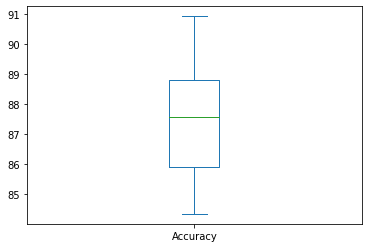

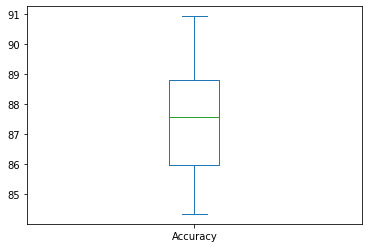

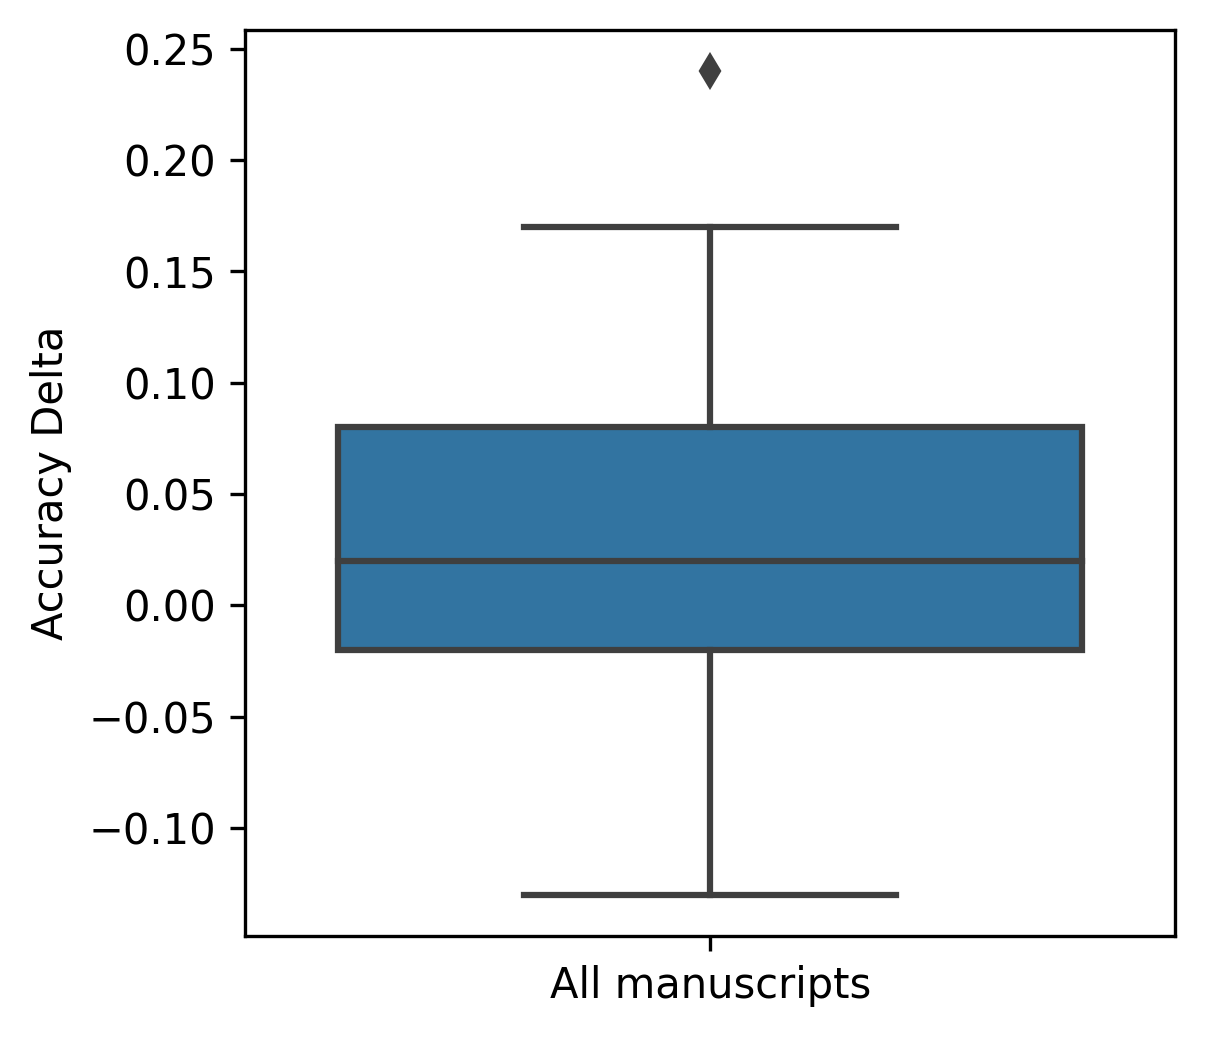

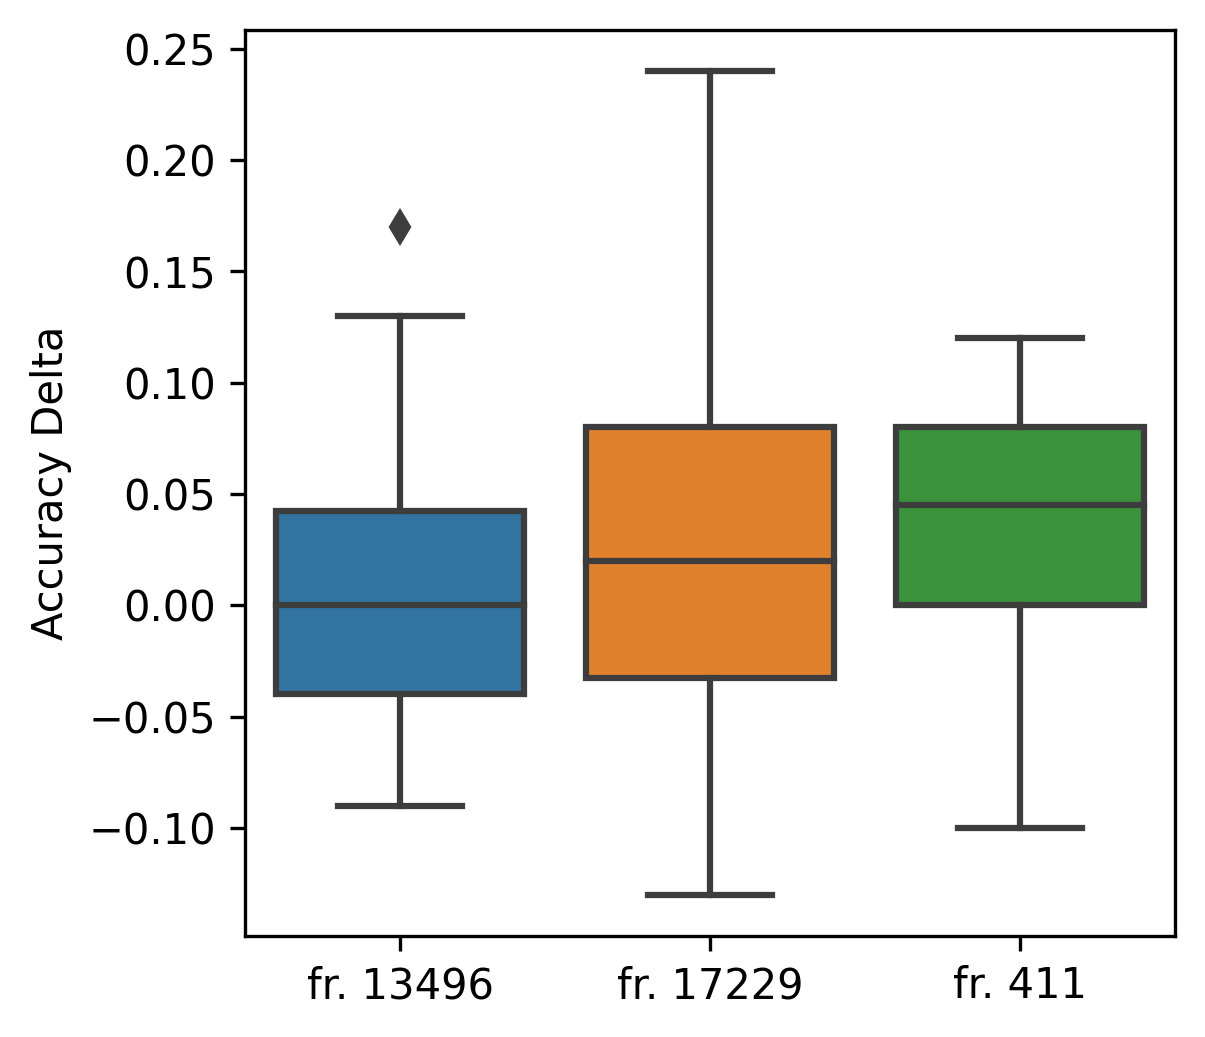

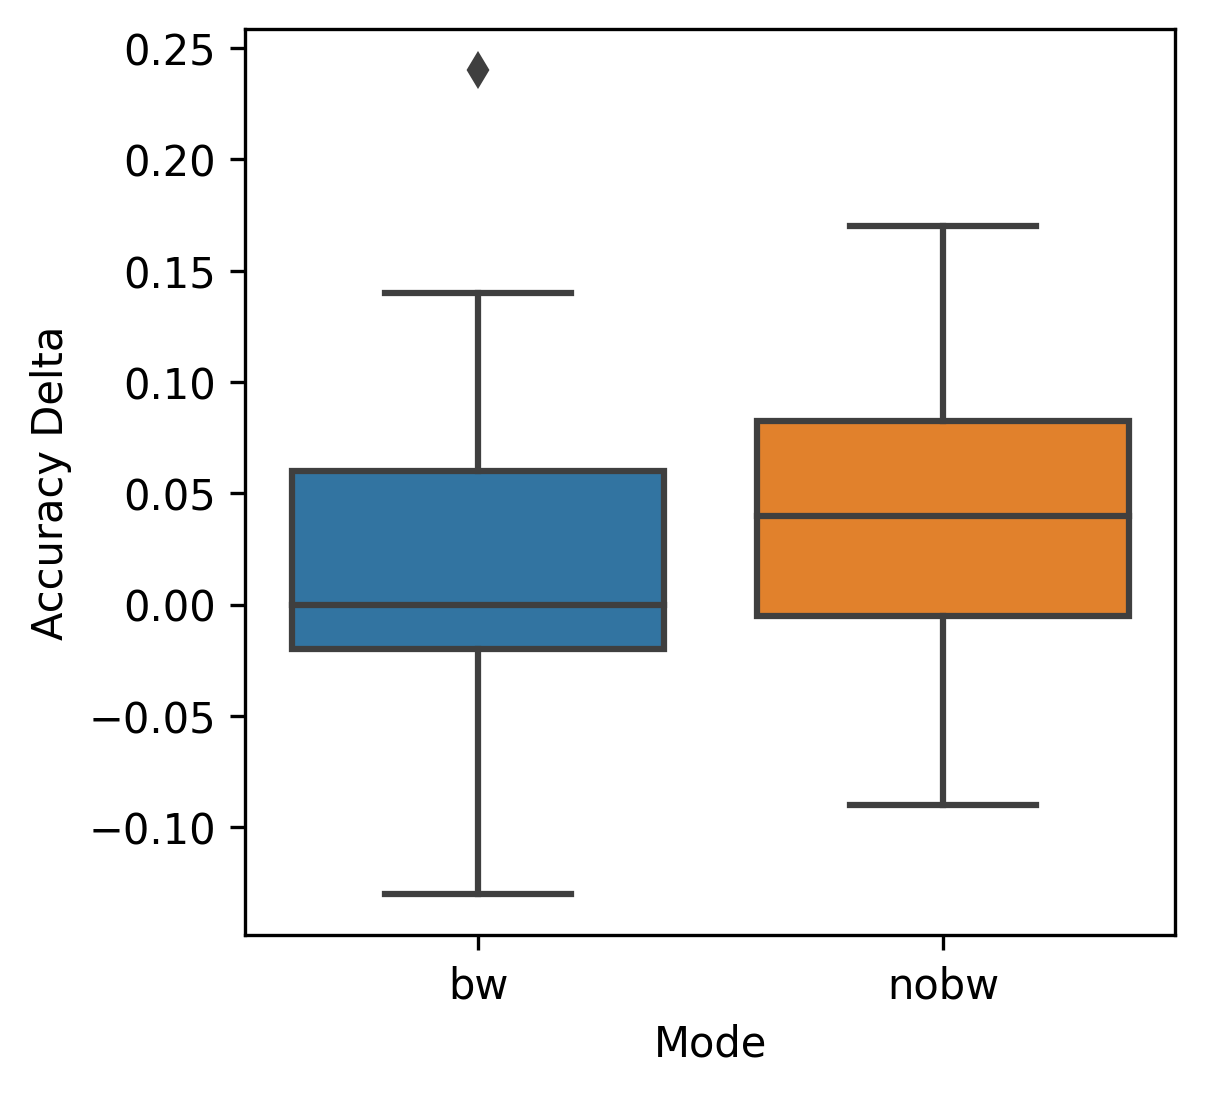

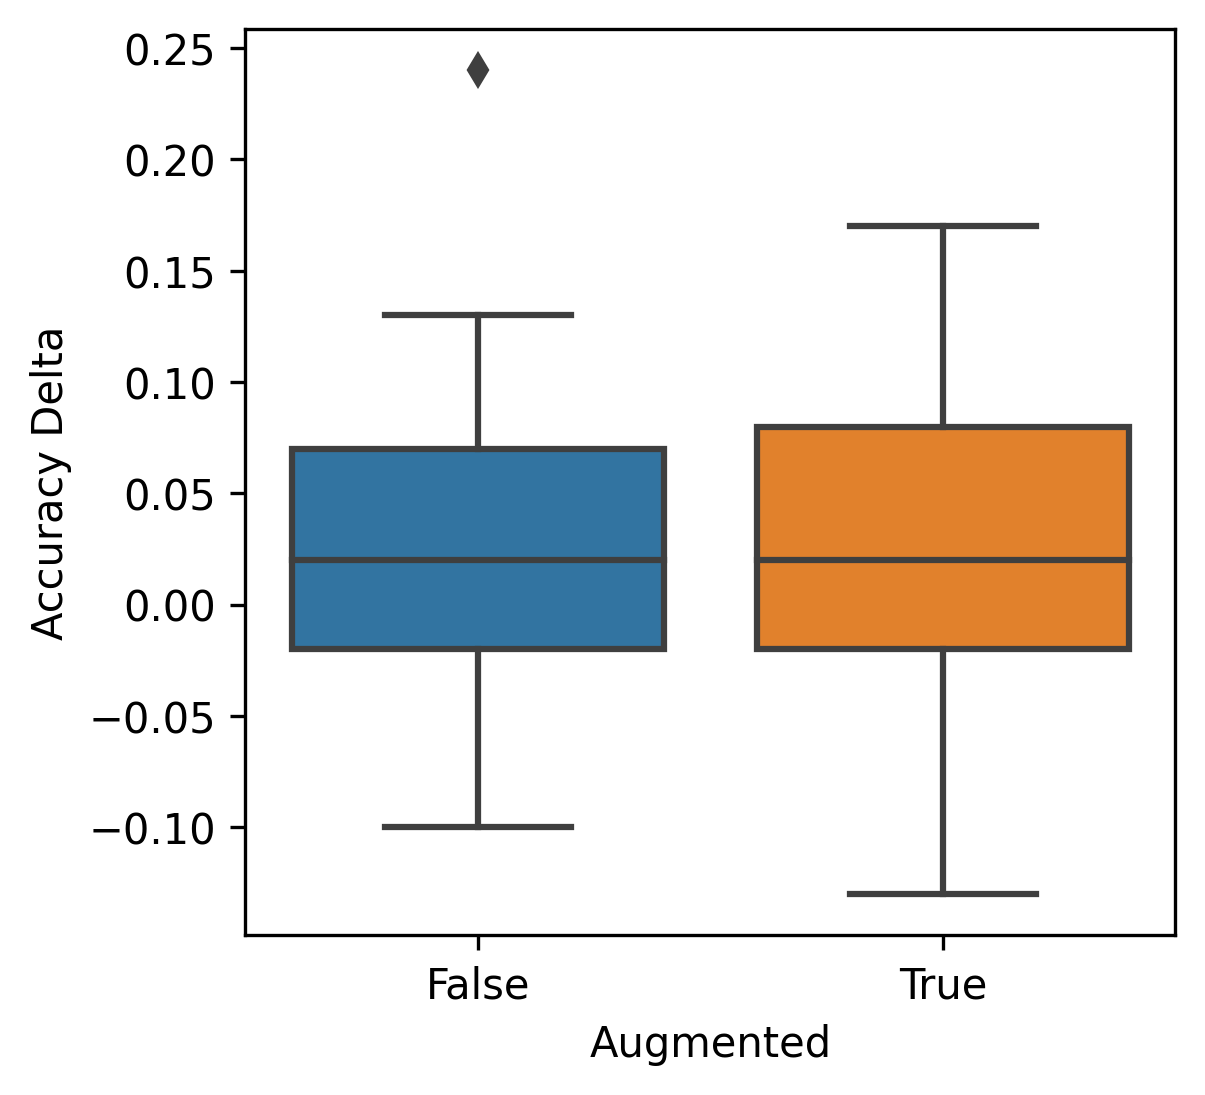

STD 0.06373389838948812,
Median 0.01999999999999602,
Mean 0.025416666666666643,
Runs 120
       Accuracy Delta
count      120.000000
mean         0.025417
std          0.063734
min         -0.130000
25%         -0.020000
50%          0.020000
75%          0.080000
max          0.240000


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


SORT_ORDER = ["Mode", "MSS", "Score", "Augmented"]

def get_metric(metric="Accuracy"):

    df_colorized = df[df["Colorized"] == True].sort_values(by=SORT_ORDER)[metric].astype(float)
    df_microfilm = df[df["Colorized"] == False].sort_values(by=SORT_ORDER)[metric].astype(float)
    
    accuracy_final = list(df_colorized.to_numpy() - df_microfilm.to_numpy())
    recomposed_df = pandas.DataFrame([
        {"Accuracy Delta": a, "Mode": r.Mode, "MSS": r.MSS, "Augmented": r.Augmented}
        for a, (_, r) in zip(accuracy_final, df[df["Colorized"] == False].sort_values(
            by=SORT_ORDER).iterrows())
        ])

    fig, ax = plt.subplots(figsize=(4,4), dpi=300)
    sns.boxplot(y="Accuracy Delta", data=recomposed_df, ax=ax)
    ax.set_xticklabels(["All manuscripts"])
    plt.show()


    fig, ax = plt.subplots(figsize=(4,4), dpi=300)
    sns.boxplot(y="Accuracy Delta", x="MSS", data=recomposed_df, ax=ax)
    ax.set_xlabel("")
    plt.show()

    fig, ax = plt.subplots(figsize=(4,4), dpi=300)
    sns.boxplot(y="Accuracy Delta", x="Mode", data=recomposed_df, ax=ax)
    plt.show()

    fig, ax = plt.subplots(figsize=(4,4), dpi=300)
    sns.boxplot(y="Accuracy Delta", x="Augmented", data=recomposed_df, ax=ax)
    plt.show()

    print(f"STD {recomposed_df['Accuracy Delta'].std()},\n"
          f"Median {recomposed_df['Accuracy Delta'].median()},\n"
          f"Mean {recomposed_df['Accuracy Delta'].mean()},\n"
          f"Runs {len(recomposed_df)}")
    
    print(recomposed_df.describe())
    
get_metric()

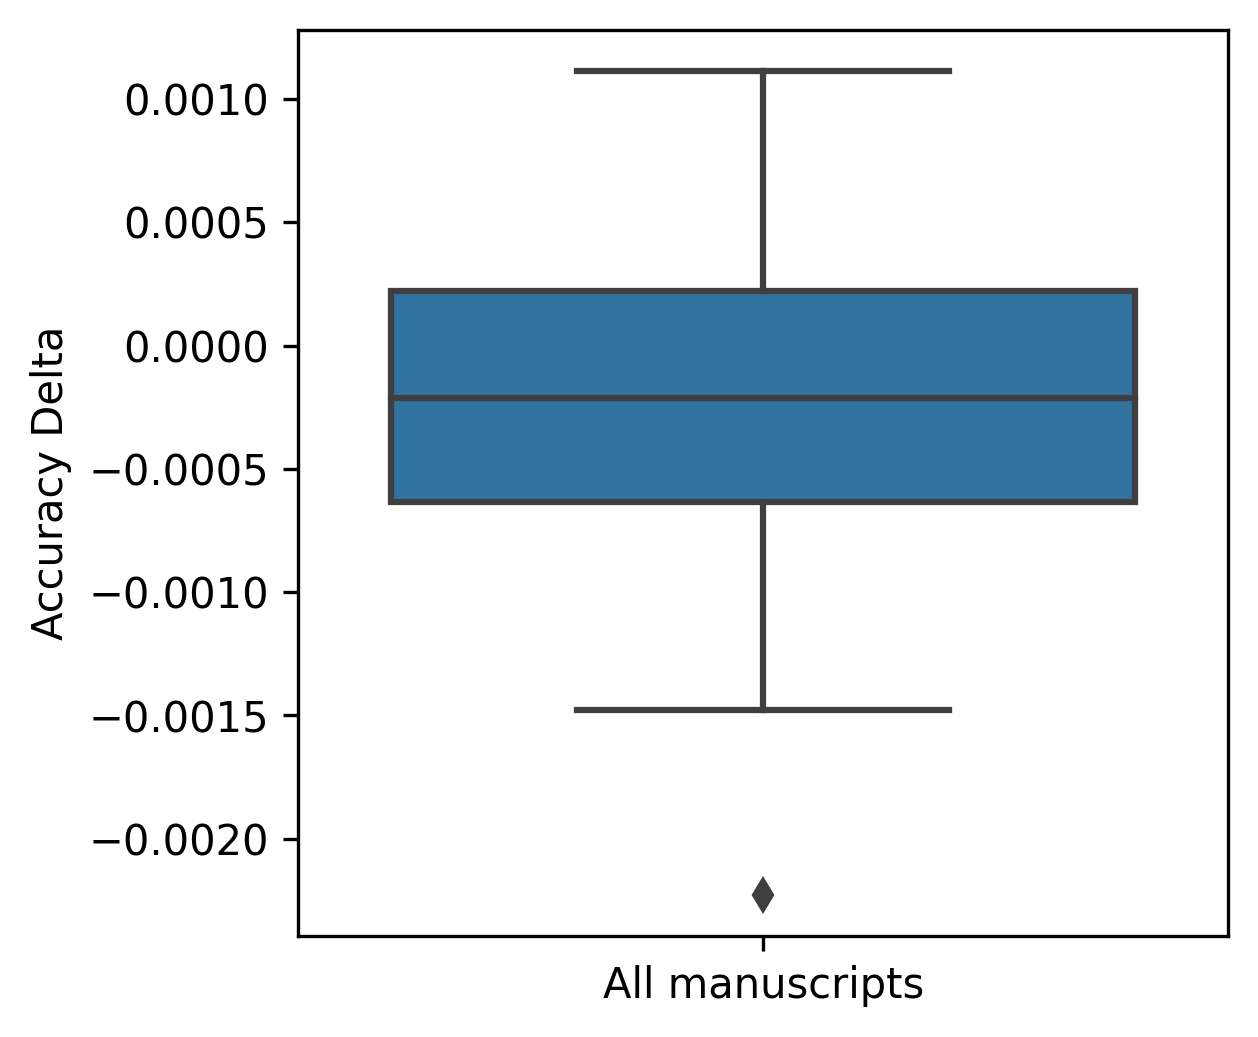

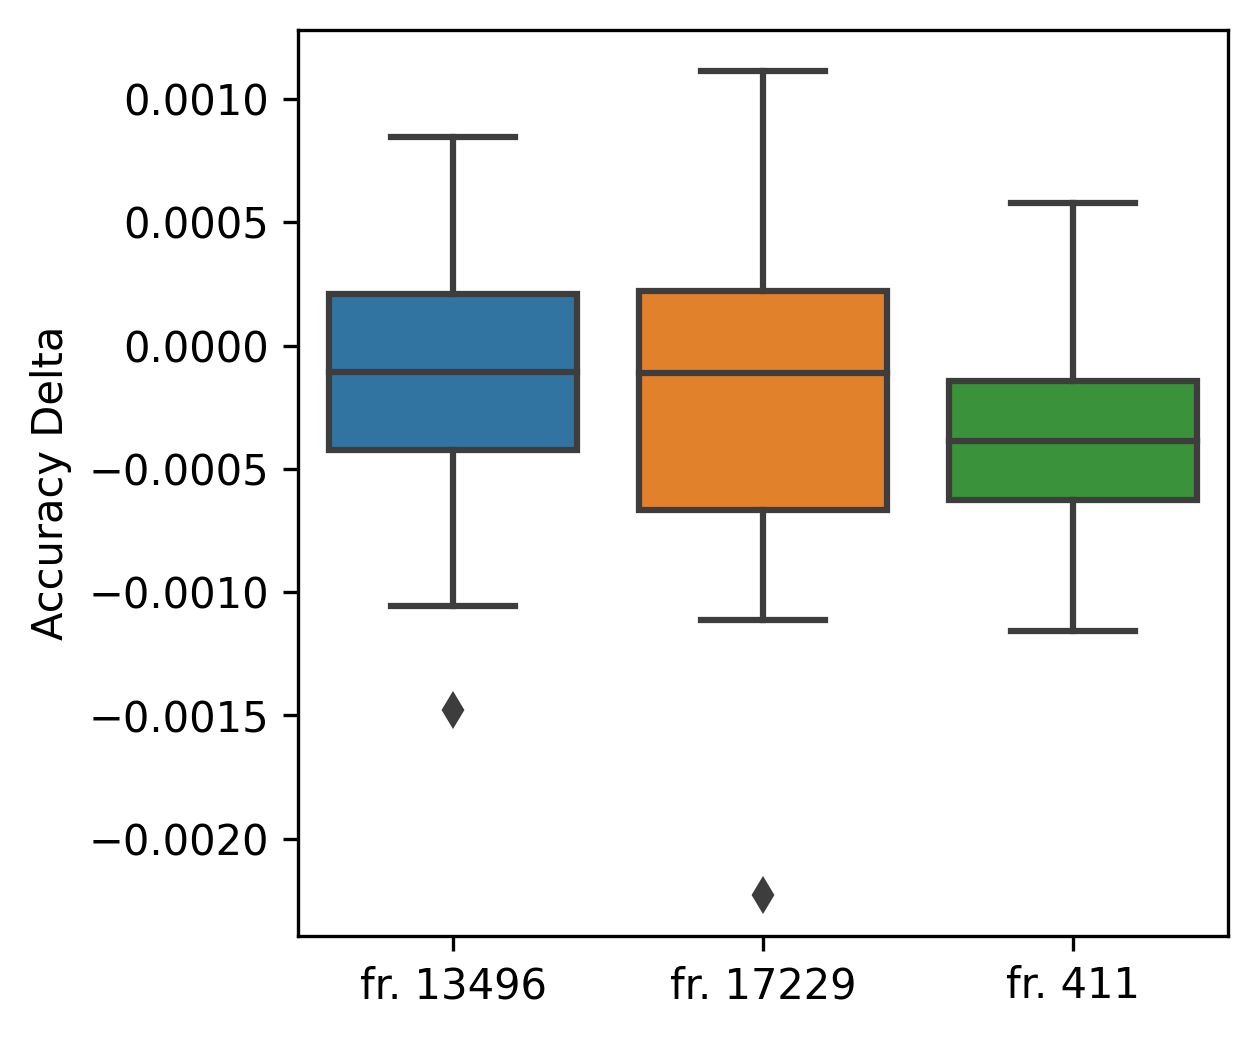

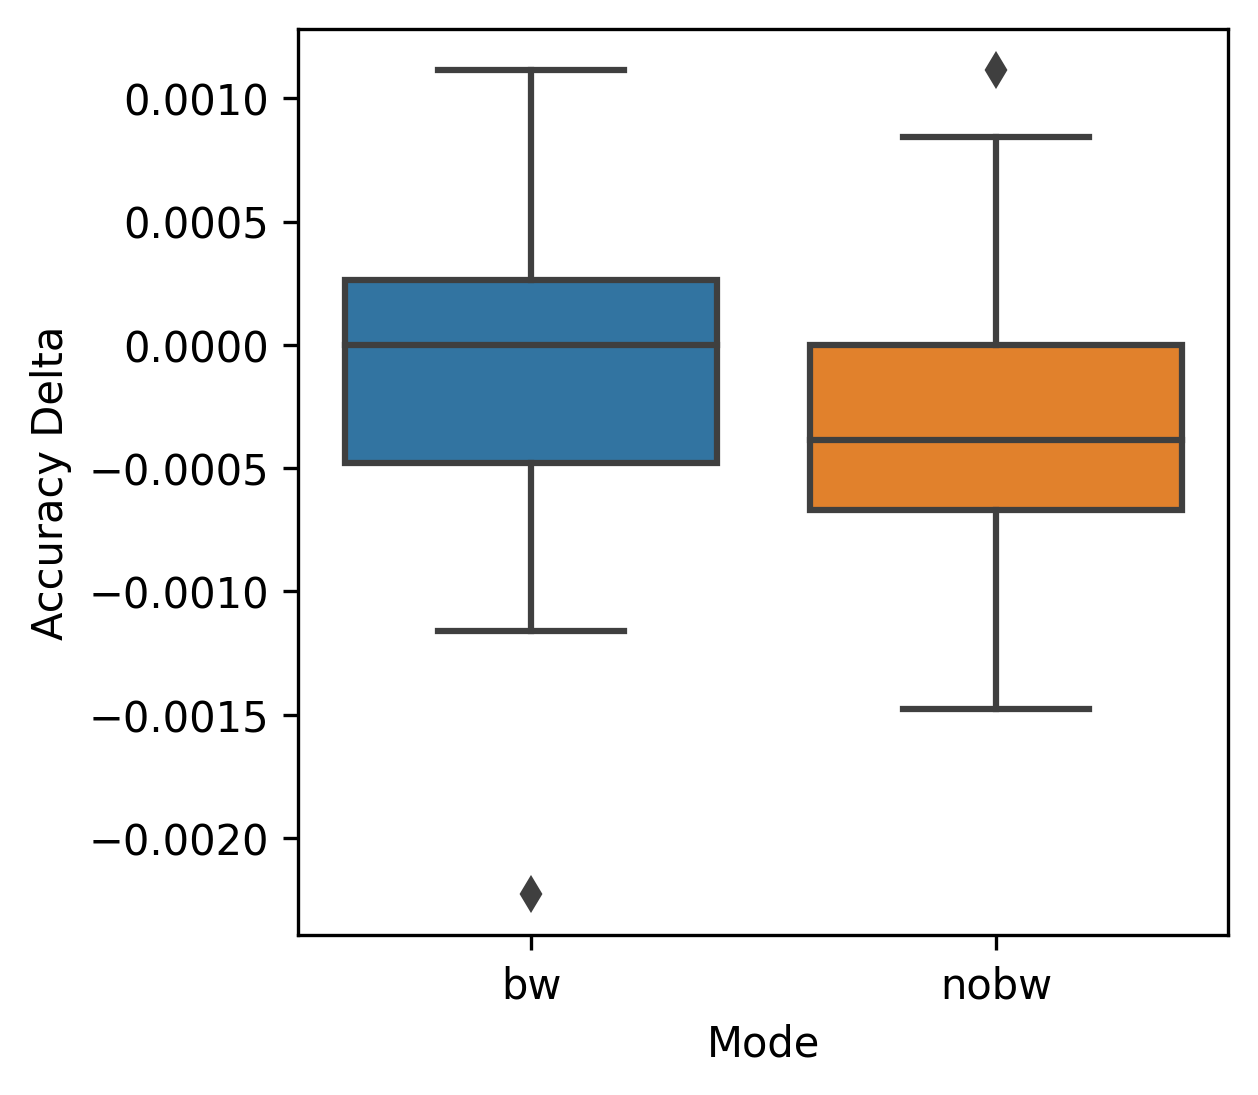

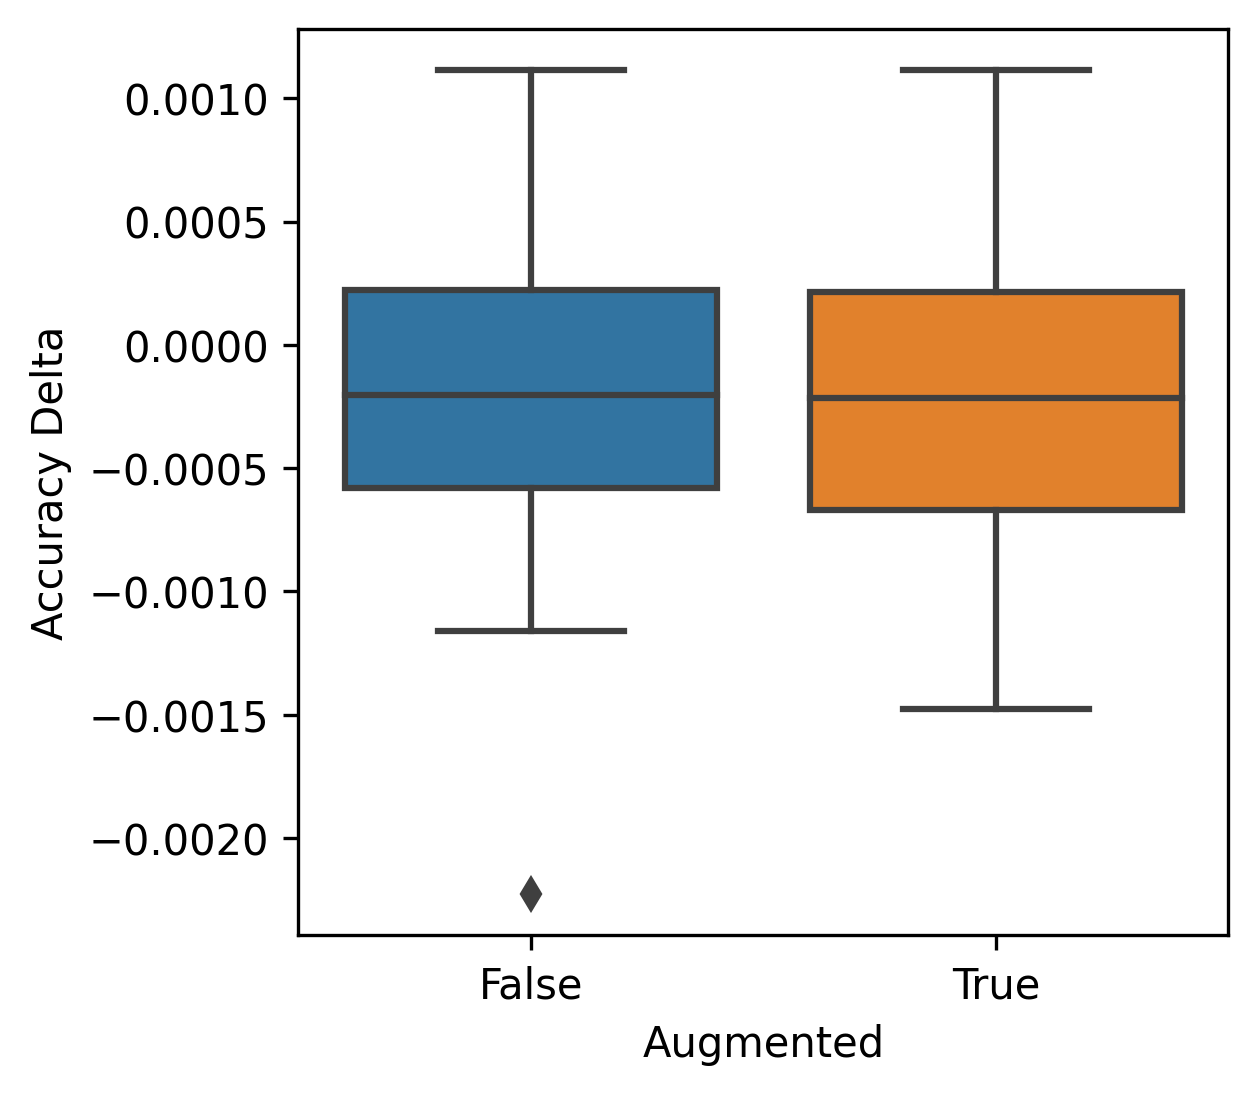

STD 0.0005699641891597694,
Median -0.00021114864864864996,
Mean -0.00021173663038686144,
Runs 120
       Accuracy Delta
count      120.000000
mean        -0.000212
std          0.000570
min         -0.002227
25%         -0.000633
50%         -0.000211
75%          0.000223
max          0.001114


In [5]:

get_metric("NonSpaceAccuracy")

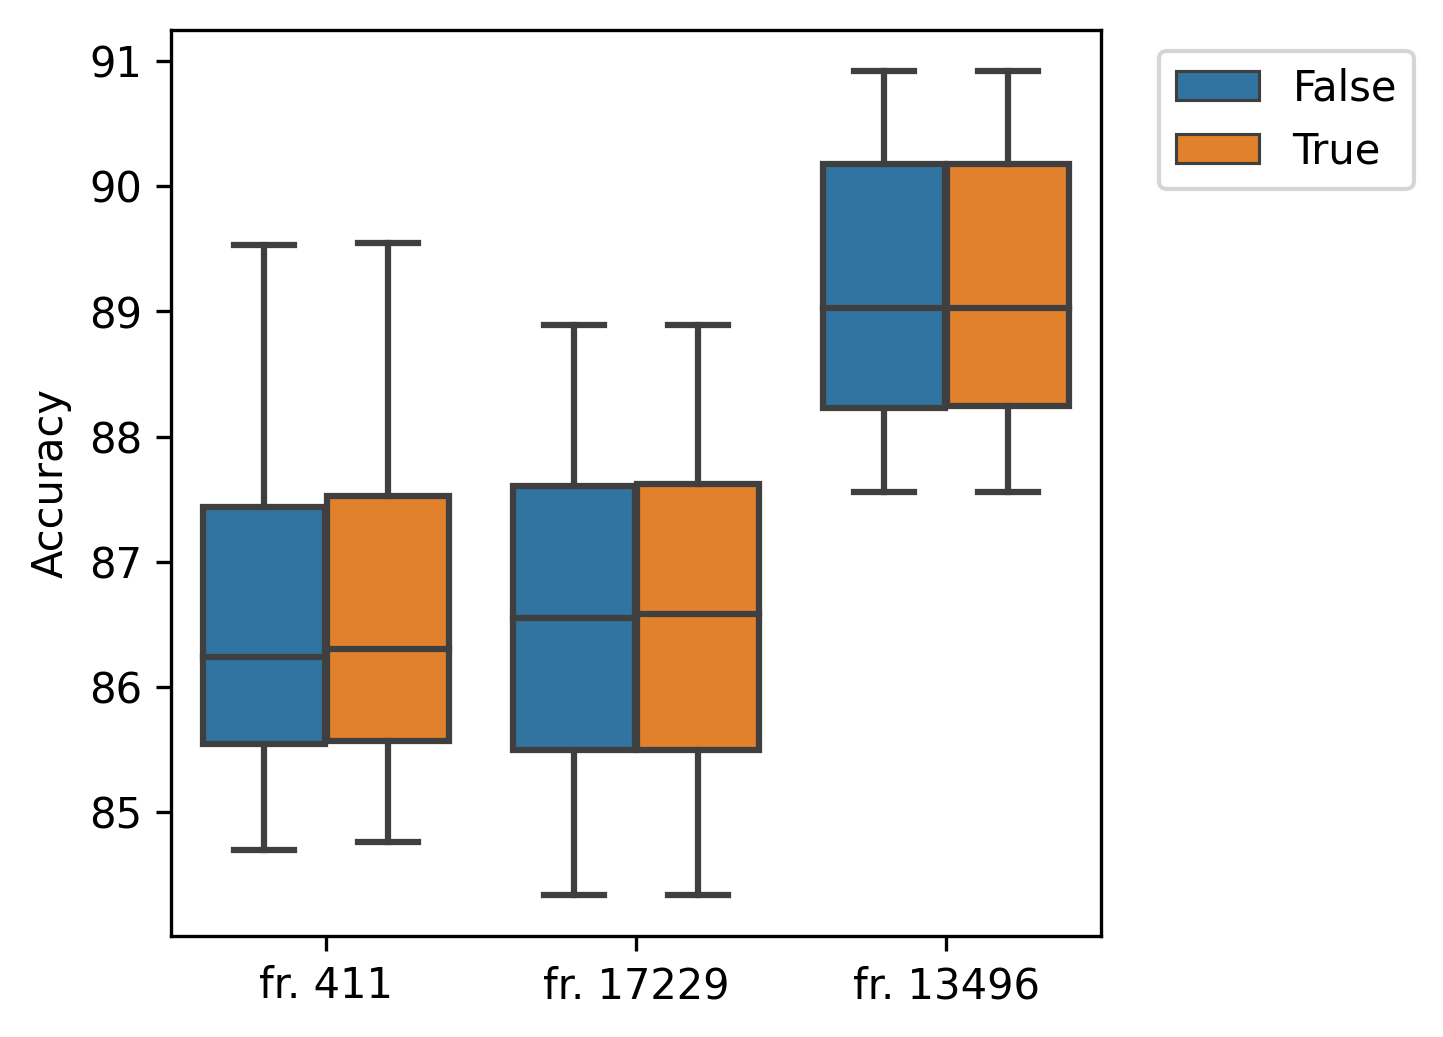

In [31]:
df2 = pandas.DataFrame(data[1:], columns=data[0])
#df2.loc[df2.Mode == "bw"].Mode = "BW"
#df2.loc[df2.Mode == "nobw"].Mode = "NOBW"


fig, ax = plt.subplots(figsize=(4,4), dpi=300)
sns.boxplot(y="Accuracy", x="MSS", hue="Colorized", data=df2, ax=ax)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.set_xlabel("")
plt.show()
